# Qiskit implementation of the Grover algorithm

## Simple example for $N=4$:

We want to use the Qiskit library to write some simple implementation of the Grover algorithm (see the lectures for more details)

The first thing que need to do is to install the latest versions of Qiskit (Qiskit 1.0.0).
We need to install:

*   Qiskit itself
*   Qiskit Aer, a simulator (basically, this package will run our desired algorithm a high number of times in order to gather statistics on the results)



In [1]:
pip install qiskit

In [2]:
pip install qiskit-aer

Now we import the modules which we will use.
For the time being, we are interested in QuantumCircuit and ClassicalRegister

*   QuantumCircuit: QuantumCircuit is used to, in technical terms, instantiate an object in a class. Basically, it is used to create quantum circuits with parameters of interest and a special structure which can then be used to do quantum operations.
*   ClassicalRegister: if you recall from the seminar, one model for quantum computations considers the possibility of combining the classical operations (e.g. sending data via a cable) with quantum operations, in order to gain the best of both worlds. ClassicalRegister, in a way, is precisely just that. Whenever we want to do a measurement of a quantum operation, we get a "classical" result (i.e. the result of said measurement can be stored with classical bits), which we store in a ClassicalRegister, for posterior processing



In [3]:
from qiskit import *
from qiskit import QuantumCircuit, ClassicalRegister

We define the number of qubits we want to work with. If we want to work with $N=4$ possible states (namely, $|{00}\rangle, |{01}\rangle, |{10}\rangle, |{11}\rangle$) we need:

$$
  n = \log_{2} N,
$$

which gives $n=2$. This is so since a chain of $n$ qubits has a total of $N=2^n$ possible states. With that settled, we will instantiate a quantum circuit with $n=2$



:-) Exercise: How many different states there will be if we consider $n=3$ and $n=4$ qubits?


In [4]:
n=2
grover_circuit = QuantumCircuit(n)

So, now we have to actually write and implement the quantum operations in the Grover algorithm.
We will do them, step by step, so hopefully everything is clear.

### 1st: Initialization

What does this initialization procedure mean? Two things.

*   We need to define our target state, that is, which state is the one which we want to distinguish with high-accuracy. In this example, we have four states  $\{|{00}\rangle, |{01}\rangle, |{10}\rangle, |{11}\rangle\}$ and our target state is $|\omega\rangle=|11\rangle$.

>> What does this mean? If you remember from the seminar, we used the states of a system as a fundamental block of quantum mechanics. If we know the state of the system, we know of all of its properties and behaviour, right?
The most general state of this quantum circuit will be something like
$$
  |\psi_0 \rangle = a {00}\rangle + b |{01}\rangle + c |{10}\rangle + d |{11}\rangle,
$$
provided $a^2+b^2+c^2+d^2=1$.

So we want to make a series of quantum operations such that, we _always_ get a final state $|\psi_{f}\rangle = |11\rangle$.


* The second step is to provide a "guess" of the initial state of the system.
A simple initial system is to say that, since we do not know much about the quantum circuit, we propose that all four states have the same probability,

$$
  |\psi_0\rangle = \frac{1}{4} {00}\rangle + \frac{1}{4} |{01}\rangle + \frac{1}{4} |{10}\rangle + \frac{1}{4} |{11}\rangle,
$$

In quantum computation, the proper way to do this is to use a so-called Hadamard gate.

The following piece of code is a fancy way to initialize the state of the quantum circuit

In [5]:
def initialize_S(qc, qubits):
  for q in qubits:
    qc.h(q)
  return qc

This function takes two inputs:

1. The quantum circuit,
2. and the qubits, which, by convention, are numbered from 0 onwards. So we have two qubits, qubit 0 and qubit 1. These are just labels, though, nothing else. Not states, not probabilities, we could also call them "Alice" and "Bob" or whatever we want.

We apply this function on the quantum circuit.

In [6]:
grover_circuit = initialize_S(grover_circuit, [0,1])
grover_circuit.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

## 2nd: Repetition of operations

Now we must repeat two kinds of operations:

1. an oracle, which we call $U_\omega$,
2. and a rotation, which we call $U_S$,

How many repetitions should we do until we find the state with 100% accuracy? These two steps must be done *around* $r(N) = \frac{\pi}{4} \sqrt{N}.$. For $N=4$, $r\approx 1.57$, so technically we should repeat these two operations twice.
In this *very simple example*, it turns out we need only to repeat once these steps, i.e.

1. perform oracle,
2. perform rotation,

in order to find the state $|11\rangle$. Doing it twice would be overkill.

### 2.1 The oracle

We now apply the oracle. What is the oracle?

>> It is a quantum operation defined as follow:

* $U_\omega |{a}\rangle= |a\rangle$ if $|a\rangle \neq |\omega\rangle$, and
* $U_\omega |{a}\rangle= (-1)|a\rangle$ if $|a\rangle = |\omega\rangle$

So this quantum operation, should be the identity for $|{00}\rangle, |{01}\rangle, |{10}\rangle$ but have a minus for the $|11\rangle$ state.
The correct quantum operation is the [Controlled-Z gate](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.CZGate), in qiskit, known as "cz".

In [7]:
grover_circuit.cz(0,1) # the oracle itself that acts on both qubits, q0 and q1.
oracle_ex=grover_circuit.to_gate() # we tell qiskit that the previous operation was the oracle
oracle_ex.name="U_w" # we assign it a name
grover_circuit.draw()

┌───┐   
q_0: ┤ H ├─■─
     ├───┤ │ 
q_1: ┤ H ├─■─
     └───┘

:-) Exercise: try to find different oracles for different target states, e.g. try it with $|01\rangle$ instead of the $|11\rangle$ and play a little with the new oracle.  

### 2.2 The rotation

Now, we must apply a rotation.
For the time being, with the tools given in the seminar, we are not yet ready to write a mathematical description of the rotation, since it involves introducing something called "kets" and "bras". Mathematically, this would be

$$
  U_S = 2 |\psi_0 \rangle\langle \psi_0| - I,
$$

where $I$ is the identity.
Suffice it to say, we will apply the following operations which mathematically give the same result as the previous quantum operation but are already defined in Qiskit

In [8]:
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.measure_all()
grover_circuit.draw()

┌───┐   ┌───┐┌───┐   ┌───┐ ░ ┌─┐   
   q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├─░─┤M├───
        ├───┤ │ ├───┤├───┤ │ ├───┤ ░ └╥┘┌─┐
   q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├─░──╫─┤M├
        └───┘   └───┘└───┘   └───┘ ░  ║ └╥┘
meas: 2/══════════════════════════════╩══╩═
                                      0  1

So in the previous diagram we found the quantum circuit, with the M boxes representing measurements.
These measurements are classical results, which are then going to be processed by the classical register.

Recall that quantum mechanics is, at a fundamental level, a probabilistic theory. So, in order to check correctness of a result, we have to make a very large number of experiments, gather statistics and, with these results, make some conclusion.

With the help of Qiskit.Aer and Qiskit.Visualization we will do precisely just that.

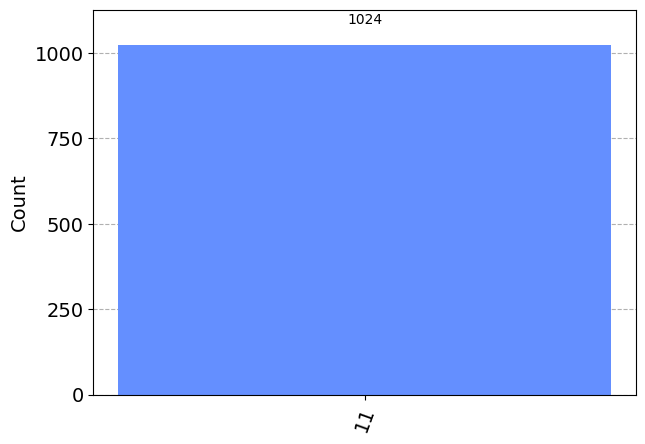

In [9]:
from qiskit_aer import Aer
qasm_sim = Aer.get_backend('qasm_simulator') # a simulator which will run the previous Grover circuit a very large number of times
result=qasm_sim.run(grover_circuit).result() # these results will be fed to the classical register and we will plot the result
counts=result.get_counts()

from qiskit.visualization import plot_histogram

plot_histogram(counts) # here we will plot a histogram, basically a plot showing how many times we found the target state.


From this, we find that from 1024 experiments, we correctly found the target state 1024 times, which is perfect accuracy.

To summarize, the Grover circuit is a good example of potential applications of quantum computation for more complicated problems since it shows how, by using classical and quantum operations both, you can solve this linear search problem in $O(\sqrt{N})$ steps, instead of the worst-case-scenario of $O(N)$ steps needed if we were restricted to classical computation only.